In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [6]:
corpus = '''Mechanic repairs broken engine. Farmer harvests ripe crops. Musician plays soulful melody. Mother comforts crying baby. Gardener plants colorful flowers.'''
corpus

'Mechanic repairs broken engine. Farmer harvests ripe crops. Musician plays soulful melody. Mother comforts crying baby. Gardener plants colorful flowers.'

In [ ]:
def training_data_generator(corpus, window_size):   
    # Indexing and Vocabulary Generation
    sentences = corpus.split('.')
    indexed_sentences = []
    vocab = {}
    vocab_idx = -1
    for i in range(len(sentences)):
        sentences[i] = sentences[i].strip().split()
        if len(sentences[i]) > 0:
            indexed_sentences.append([])
            for j in range(len(sentences[i])):
                sentences[i][j] = sentences[i][j].lower()
                if sentences[i][j] not in vocab:
                    vocab_idx +=1
                    vocab[sentences[i][j]] = vocab_idx
                    indexed_sentences[-1].append(vocab_idx)
                else:
                    indexed_sentences[-1].append(vocab[sentences[i][j]])
    vocab_size = len(vocab)

    # Training Dataset Generation
    X_train = []
    y_train = []
    for i in range(len(indexed_sentences)):
        for j in range(len(indexed_sentences[i])):
            for k in range(1, window_size+1):
                center_word_ohe_vector = np.zeros(vocab_size)
                center_word_ohe_vector[indexed_sentences[i][j]] = 1
                zeros_vector = np.zeros(vocab_size)
                c_left_idx = j - k
                if c_left_idx >= 0:
                    X_train.append(center_word_ohe_vector)
                    y_train.append(np.copy(zeros_vector))
                    y_train[-1][indexed_sentences[i][c_left_idx]] = 1
                c_right_idx = j + k
                if c_right_idx < len(indexed_sentences[i]):
                    X_train.append(center_word_ohe_vector)
                    y_train.append(np.copy(zeros_vector))
                    y_train[-1][indexed_sentences[i][c_right_idx]] = 1
                    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    return X_train, y_train, vocab

In [ ]:
X_train, y_train, vocab = training_data_generator(corpus,2)

In [9]:
print('First five words in vocabulary: ', list(vocab.keys())[:5])

First five words in vocabulary:  ['mechanic', 'repairs', 'broken', 'engine', 'farmer']


In [10]:
total_training_examples, vocab_size = X_train.shape
print(f'Total training examples: {total_training_examples}')
print(f'OHE vector size / Vocabulary size: {vocab_size}')

Total training examples: 50
OHE vector size / Vocabulary size: 20


In [11]:
class AdamOptimizer:
    def __init__(self, alpha, params, beta1=0.9, beta2=0.999, epsilon=10e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.moments = []
        self.epoch = 0
        if not params:
            raise Exception("Parameters can't be undefined!")
        for i in range(len(params)):
            self.moments.append(
                {
                    'V': np.zeros_like(params[i]),
                    'S': np.zeros_like(params[i])
                }
            )

    def update(self, params=[], grads=[]):
        params_len = len(params)
        grads_len = len(grads)
        if params_len != grads_len or params_len == 0:
            raise Exception("Empty or Inconsistant Parameters and Gradients List!")

        self.epoch += 1

        for i in range(grads_len):
            # Update biased first moment estimate
            self.moments[i]['V'] = self.beta1 * self.moments[i]['V'] + (1 - self.beta1) * grads[i]
            # Update biased second raw moment estimate (RMSProp part)
            self.moments[i]['S'] = self.beta2 * self.moments[i]['S'] + (1 - self.beta2) * np.square(grads[i])
            # Compute bias-corrected first moment estimate
            VdW_corrected = self.moments[i]['V'] / (1 - self.beta1 ** self.epoch)
            # Compute bias-corrected second raw moment estimate (RMSProp part)
            SdW_corrected = self.moments[i]['S'] / (1 - self.beta2 ** self.epoch)
            # Update parameters
            params[i] -= self.alpha * VdW_corrected / (np.sqrt(SdW_corrected) + self.epsilon)
        
        return params

In [ ]:
class SkipGram:
    def __init__(self, embedding_size, vocab):
        self.vocab = vocab
        self.vocab_rev = {v: k for k, v in vocab.items()}   # Used in finding context words using cosine similarity
        self.vocab_size = len(vocab)
        self.embedding_size = embedding_size
        self.reset_weights()

    def softmax(self, H):
        Yhat = np.exp(H - np.max(H, axis=0))    # Subtracting max logit to avoid overflow and underflow
        return Yhat / Yhat.sum(axis=0)

    def reset_weights(self):
        self.W = np.random.randn(self.vocab_size, self.embedding_size) * np.sqrt(2 / (self.vocab_size + self.embedding_size))
        self.Wprime = np.random.randn(self.embedding_size, self.vocab_size) * np.sqrt(2 / (self.embedding_size + self.vocab_size))
        return

    def update(self, total_training_examples, dL_by_dW, dL_by_dWprime):
        norm = 1/total_training_examples

        dL_by_dW *= norm
        dL_by_dWprime *= norm

        self.W, self.Wprime = self.optimizer.update(params=[self.W, self.Wprime], grads=[dL_by_dW, dL_by_dWprime])

        return
    
    def forward_prop(self, X_train):
        H = self.W.T @ X_train
        U = self.Wprime.T @ H
        Yhat = self.softmax(U)
        return H, Yhat
    
    def backprop(self, X_train, Y_train, H, Yhat):
        temp = Yhat - Y_train
        dL_by_dWprime = H @ temp.T
        dL_by_dW = X_train @ (self.Wprime @ temp).T
        return dL_by_dW, dL_by_dWprime

    def calc_cce(self, Yhat, true_labels):
        # Clip y_pred to avoid log(0) and very small values that may cause numerical instability
        Yhat = np.clip(Yhat, 1e-15, 1 - 1e-15)

        total_loss = -np.sum(true_labels * np.log(Yhat+10e-10))

        return total_loss
    
    def cosine_similarity(self, v1, v2):
        """
        Parameters:
        - v1, v2: NumPy arrays representing the word embeddings of two words.
        
        Returns:
        - cosine_similarity: A scalar value representing the cosine similarity between the two vectors.
        """
        dot_product = np.dot(v1, v2)
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        return dot_product / (norm_v1 * norm_v2)
    
    def get_context_words(self, word, num_context_words):
        word = word.lower()
        if word not in vocab:
            raise ValueError(f"Word '{word}' not found in the vocabulary.")

        # Get the index of the center word
        center_word_idx = vocab[word]
        
        # Get the embedding of the center word
        center_embedding = self.W[center_word_idx]

        # Compute cosine similarity between the center word and all other words
        similarities = []
        for idx, context_embedding in enumerate(self.W):
            if idx != center_word_idx:  # Skip the center word
                similarity = self.cosine_similarity(center_embedding, context_embedding)
                similarities.append((idx, similarity))

        # Sort the context words based on similarity in descending order
        similarities.sort(key=lambda x: x[1], reverse=True)

        # Return the top 'num_context_words' context words
        context_words_with_sim = [(self.vocab_rev[idx], similarity) for idx, similarity in similarities[:num_context_words]]
        return context_words_with_sim

    def train(self, X_train, Y_train, epochs, lr=0.1):
        X_train = X_train.T
        Y_train = Y_train.T
        total_training_examples = X_train.shape[-1]
        training_loss_history = []
        self.reset_weights()
        self.optimizer = AdamOptimizer(alpha=lr, params=[self.W, self.Wprime])
        for epoch in range(epochs):
            dL_by_dW = np.zeros((self.vocab_size, self.embedding_size))
            dL_by_dWprime = np.zeros((self.embedding_size, self.vocab_size))
            H, Yhat = self.forward_prop(X_train)
            dL_by_dW, dL_by_dWprime = self.backprop(X_train, Y_train, H, Yhat)
            self.update(total_training_examples, dL_by_dW, dL_by_dWprime)
            loss = self.calc_cce(Yhat, Y_train) / total_training_examples
            training_loss_history.append(loss)
            print(f"Epoch {epoch+1:03d} | " f"Training Loss (CCE): {loss:.4f}")
        return training_loss_history

In [ ]:
sg = SkipGram(embedding_size=5, vocab=vocab)

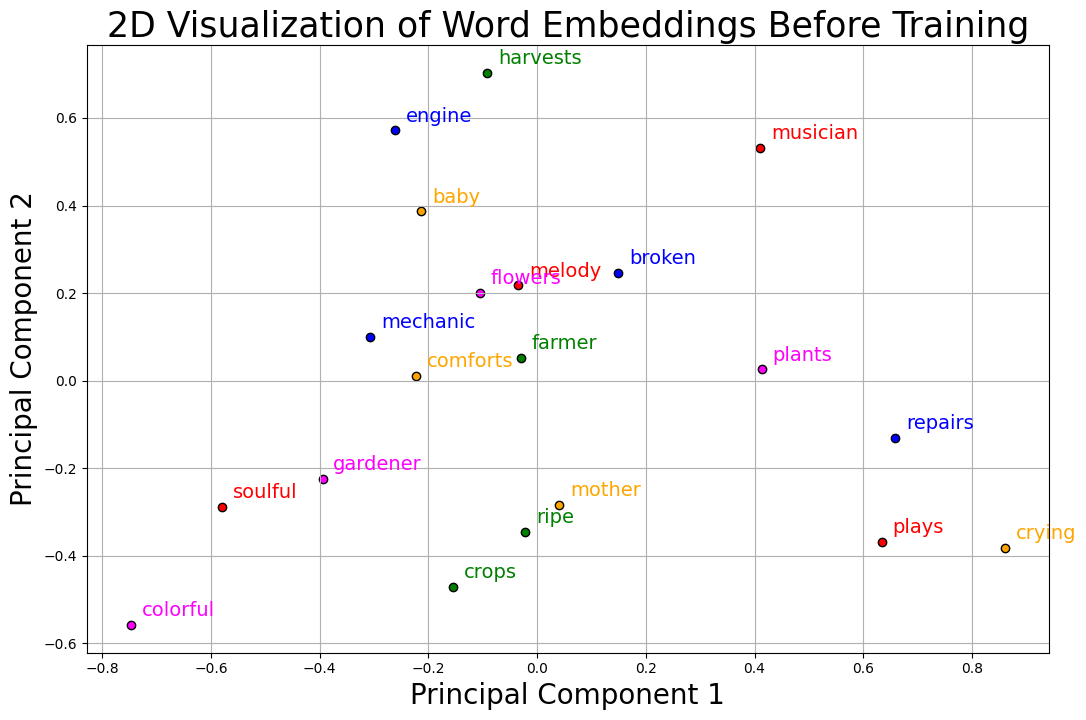

In [ ]:
# For visualization of word embeddings before training

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
data_2d = pca.fit_transform(sg.W)

# Reverse the dictionary to map indices to words for labeling in the plot
index_to_word = {index: word for word, index in vocab.items()}

# Plot the data with words as labels
plt.figure(figsize=(11, 7.3))

color_list = ['blue', 'blue', 'blue', 'blue', 'green', 'green', 'green', 'green', 'red', 'red', 'red', 'red', 'orange', 'orange', 'orange', 'orange', 'magenta', 'magenta', 'magenta', 'magenta']

for idx, (x, y) in enumerate(data_2d):
    plt.scatter(x, y, color=color_list[idx], alpha=1.0, edgecolor='k')

# Now, use the adjusted label positions
for idx, (x, y) in enumerate(data_2d):
    plt.text(x + 0.02, y + 0.02, index_to_word[idx], color=color_list[idx], fontsize=14)

plt.grid()
plt.title("2D Visualization of Word Embeddings Before Training", fontsize=25)
plt.xlabel("Principal Component 1", fontsize=20)
plt.ylabel("Principal Component 2", fontsize=20)
# plt.savefig("word embedding before training.png", dpi=300)
plt.tight_layout()
plt.show()


In [ ]:
training_loss_history = sg.train(X_train, y_train, 50, lr=0.1)

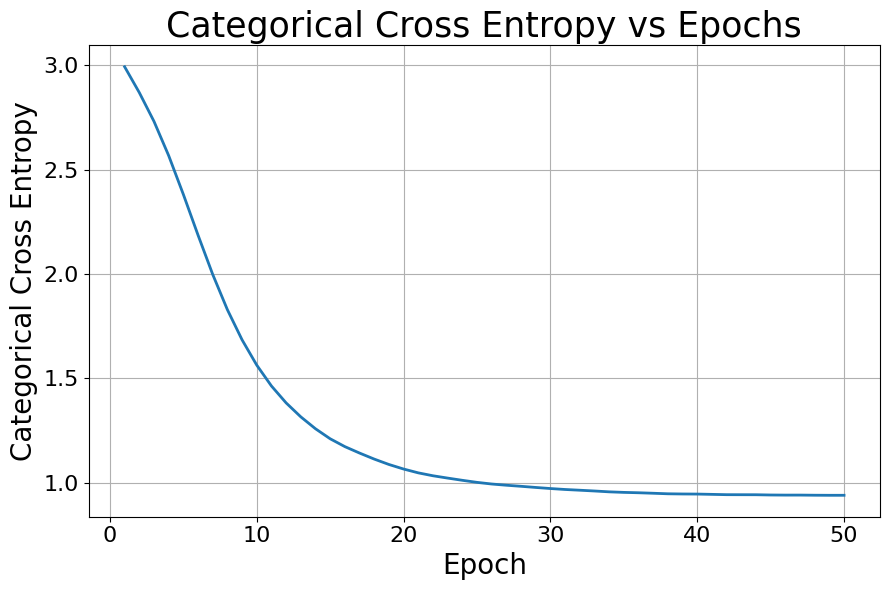

In [ ]:
iterations = np.arange(1, len(training_loss_history)+1)
plt.figure(figsize=(9, 6))
plt.plot(iterations, training_loss_history, linewidth=2)
plt.title('Categorical Cross Entropy vs Epochs', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Categorical Cross Entropy', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
# plt.savefig('cce_skipgram.png', dpi=300)
plt.show()

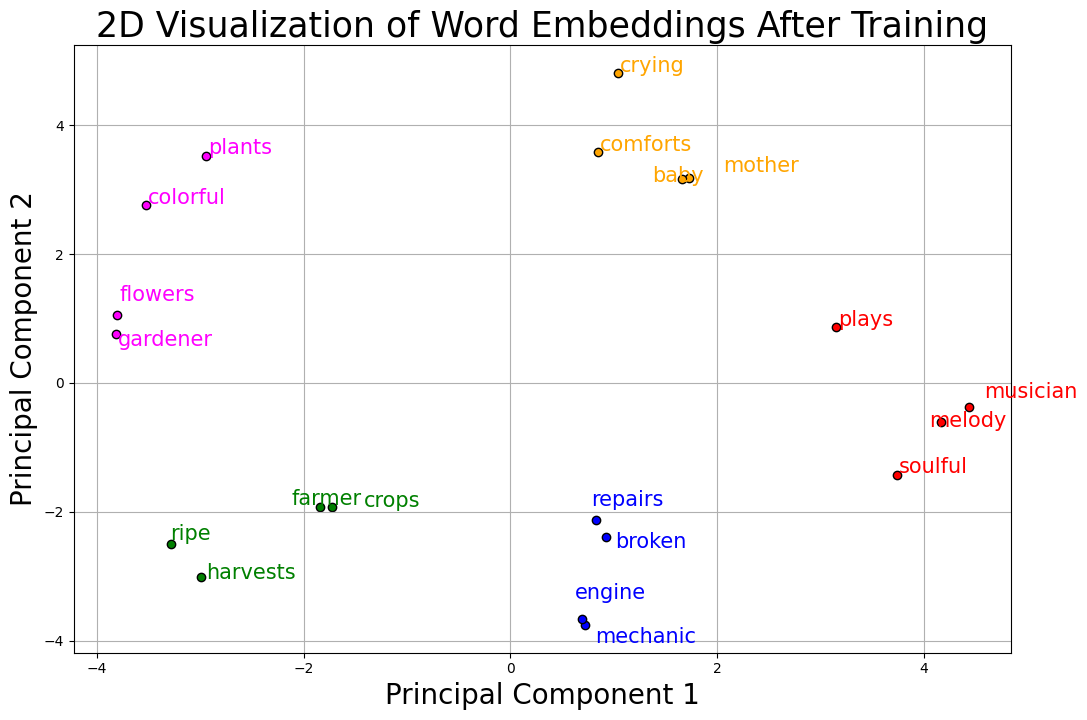

In [ ]:
# For visualization of word embeddings after training

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
data_2d = pca.fit_transform(sg.W)  # Assuming sg.W is your word embeddings

# Reverse the dictionary to map indices to words for labeling in the plot
index_to_word = {index: word for word, index in vocab.items()}

# Define a minimum distance to maintain between labels
min_distance = 0.7

# Create a list to store the final adjusted text label positions
adjusted_text_positions = np.copy(data_2d)

# Function to adjust text label positions if they are too close
def adjust_text_positions(positions, min_distance):
    adjusted_positions = np.copy(positions)
    for i in range(len(positions)):
        for j in range(i + 1, len(positions)):
            # Calculate the Euclidean distance between the text label positions
            dist = np.linalg.norm(adjusted_positions[i] - adjusted_positions[j])
            
            # If the distance is too small, adjust the positions of the labels
            if dist < min_distance:
                # Calculate the direction vector
                direction = adjusted_positions[i] - adjusted_positions[j]
                # Normalize the direction vector
                direction /= np.linalg.norm(direction)
                
                # Move the labels apart by the necessary amount (displacement)
                displacement = (min_distance - dist) / 2
                adjusted_positions[i] += direction * displacement
                adjusted_positions[j] -= direction * displacement
    return adjusted_positions

# Adjust the text label positions to ensure they do not overlap
adjusted_text_positions = adjust_text_positions(adjusted_text_positions, min_distance)

# Plot the data with words as labels
plt.figure(figsize=(11, 7.3))

color_list = ['blue', 'blue', 'blue', 'blue', 'green', 'green', 'green', 'green', 'red', 'red', 'red', 'red', 'orange', 'orange', 'orange', 'orange', 'magenta', 'magenta', 'magenta', 'magenta']

for idx, (x, y) in enumerate(data_2d):
    plt.scatter(x, y, color=color_list[idx], alpha=1.0, edgecolor='k')

# Now, use the adjusted label positions
for idx, (x, y) in enumerate(adjusted_text_positions):
    plt.text(x + 0.02, y + 0.02, index_to_word[idx], color=color_list[idx], fontsize=15)

plt.grid()
plt.title("2D Visualization of Word Embeddings After Training", fontsize=25)
plt.xlabel("Principal Component 1", fontsize=20)
plt.ylabel("Principal Component 2", fontsize=20)
# plt.savefig("word embedding after training.png", dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
center_word = "mother"
context_words = sg.get_context_words(center_word, num_context_words=3)
print(f"Context words for target word '{center_word}' are:")
print(context_words)